<a href="https://colab.research.google.com/github/r-yv/coding-exercise/blob/main/part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Accuracy: 0.7846
ROC AUC Score: 0.8254

New Customer Churn Probability: 0.7235
At Risk (1=Yes, 0=No): 1

Top Influential Features:
                                 Feature  Coefficient
1                            num__tenure    -1.408861
15                cat__Contract_Two year    -0.799500
3                      num__TotalCharges     0.737288
13          cat__Contract_Month-to-month     0.529810
9                    cat__Dependents_Yes    -0.384008
25               cat__OnlineSecurity_Yes    -0.372877
10              cat__InternetService_DSL    -0.353889
22                  cat__TechSupport_Yes    -0.338444
21  cat__TechSupport_No internet service    -0.316098
12               cat__InternetService_No    -0.316098


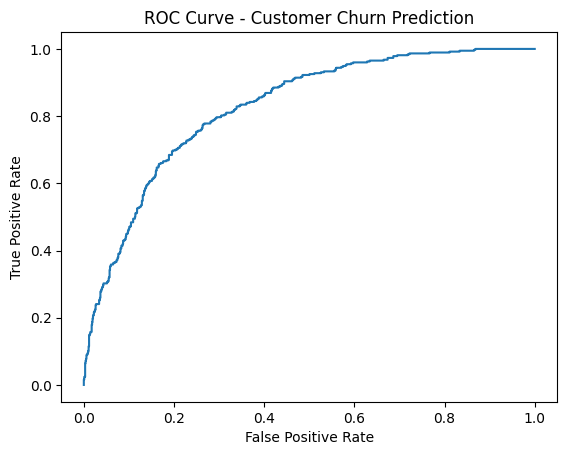


Interpretation:
- The churn probability (e.g., 0.70) means there is a 70% chance the customer will leave.
- Customers above the 0.5 threshold are classified as 'at risk'.
- Businesses can target high-risk customers with discounts, loyalty rewards, or support improvements.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score


def main():

    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

    df = df.dropna()

    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


    feature_cols = [
        "gender",
        "SeniorCitizen",
        "Partner",
        "Dependents",
        "tenure",
        "MonthlyCharges",
        "TotalCharges",
        "InternetService",
        "Contract",
        "PaymentMethod",
        "TechSupport",
        "OnlineSecurity"
    ]

    X = df[feature_cols]
    y = df["Churn"]

    numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
    categorical_features = [c for c in feature_cols if c not in numeric_features]


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ]
    )


    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    print("Model Accuracy:", round(accuracy, 4))
    print("ROC AUC Score:", round(auc_score, 4))


    new_customer = pd.DataFrame({
        "gender": ["Female"],
        "SeniorCitizen": [0],
        "Partner": ["Yes"],
        "Dependents": ["No"],
        "tenure": [5],
        "MonthlyCharges": [85.0],
        "TotalCharges": [400.0],
        "InternetService": ["Fiber optic"],
        "Contract": ["Month-to-month"],
        "PaymentMethod": ["Electronic check"],
        "TechSupport": ["No"],
        "OnlineSecurity": ["No"]
    })

    churn_probability = model.predict_proba(new_customer)[0][1]
    churn_prediction = 1 if churn_probability > 0.5 else 0

    print("\nNew Customer Churn Probability:", round(churn_probability, 4))
    print("At Risk (1=Yes, 0=No):", churn_prediction)


    feature_names = model.named_steps["preprocessor"].get_feature_names_out()
    coefficients = model.named_steps["classifier"].coef_[0]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefficients
    }).sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)

    print("\nTop Influential Features:")
    print(coef_df.head(10))

    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Customer Churn Prediction")
    plt.show()


    print("\nInterpretation:")
    print("- The churn probability (e.g., 0.70) means there is a 70% chance the customer will leave.")
    print("- Customers above the 0.5 threshold are classified as 'at risk'.")
    print("- Businesses can target high-risk customers with discounts, loyalty rewards, or support improvements.")


if __name__ == "__main__":
    main()